# 🚀 Module 3: Model Packaging and Deployment on Kubernetes

In this module, we will:
1. Build a REST API for model inference using FastAPI
2. Create a Containerfile to containerize the service
3. Deploy the container to a Kubernetes cluster (i.e. OpenShift)
4. Load a Test Dataset
5. Test the Model-API

Make sure MLflow is installed in your environment:

```bash
pip install mlflow
```

In [2]:
# Install requirements
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 207.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 190.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 236.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.2/573.2 kB 380.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 206.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 269.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 257.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 254.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 416.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 571.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 489.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

## 📦 Import Required Libraries

Before we proceed with training and tracking our machine learning model, we need to import the necessary libraries.


In [17]:
# Import necessary modules
import os
import joblib

import requests
import json

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

**************************************************
**************************************************

#### We will continue with the steps in task 6 (`Model Deploymet - Deploy on OpenShift Cluster`). 

## 🚀 Deployment on OpenShift Cluster: Test the Model-API
In this section, we deploy the trained machine learning model on an OpenShift cluster. The deployment includes deploying the image via a deployment manifest and exposing it using an internal service.

- Deploy the Image Using k8s_deployment.yaml
- Expose the Model Internally via a Service
- Expose the Model Externally via a Route (Optional)

## 🧪 Test the API Endpoint

First, we prepare the sample input data for inferencing. We load a CSV file (located in the ./data/test_model/ directory) containing sample test data and prepare it in the format expected by the deployed machine learning model.

In [ ]:
# Load the sample data CSV
test_model_path = "./data/test_model/"

sample_input = pd.read_csv(test_model_path + 'sample_input_data.csv')
# df = pd.read_csv("sample_input_data.csv")

# Define the subset of features expected by the model
model_features = [
    'temp', 'atemp', 'humidity', 'windspeed',
    'hour', 'weekday', 'season', 'holiday', 'workingday', 'weathersit'
]

# Extract the relevant subset and convert to JSON-like list of dicts
sample_X_input = sample_input[model_features]
sample_y_input = sample_input["count"]

json_input_list = sample_X_input.head(5).to_dict(orient='records')

print(json_input_list)

# Store the generated sample inference input
output_file  = f"{test_model_path}json_input_list.txt"
with open(output_file, "w") as f:
    for item in json_input_list:
        f.write(json.dumps(item) + "\n")

print(f"Saved to {output_file}")

Saved to ./data/test_model/json_input_list.txt


### Sending a Test Inference Request via curl

This command sends a test HTTP POST request to the deployed model’s prediction endpoint with a single sample input in JSON format, allowing you to verify that the model is correctly receiving and processing inference requests within the OpenShift cluster.

In [ ]:
!curl -X POST http://MODEL_API_SERVICE:80/predict \
  -H "Content-Type: application/json" \
  -d '{"temp": 0.32, "atemp": 0.3485, "humidity": 1.0, "windspeed": 0.0, "hour": 1, "weekday": 5, "season": 1, "holiday": 0, "workingday": 1, "weathersit": 2}'

{"prediction":8.54}

### Batch Inference: Sending Multiple Requests to the Model Endpoint

This section reads multiple JSON-formatted input samples from a file and sends them one-by-one to the model's prediction endpoint. It collects the predicted results and displays them alongside the actual target values in a combined output DataFrame.

In [ ]:
# ── Endpoint ─────────────────────────────────────────────────────────────
endpoint = "http://MODEL_API_SERVICE:80/predict"

# ── Read the JSON-line file and send requests ────────────────────────────
predictions = []

with open(f"{test_model_path}json_input_list.txt") as fh:
    for line_no, line in enumerate(fh, 1):
        line = line.strip()
        
        inference_request = json.loads(line)
        response = requests.post(endpoint, json=inference_request)

        if response.status_code == 200:
            # FastAPI returns {"prediction": <value>}
            predictions.append(response.json()["prediction"])

        else:
            print(f"Request failed with status code: {response.status_code}")
            print(f"Response content: {response.text}")

# ── Assemble results into a DataFrame ────────────────────────────────────
pred_df = pd.DataFrame(predictions, columns=["Predicted Count"])

# Combine predictions with actual classes
actual_class_test = sample_y_input.reset_index(drop=True)
model_output = pd.concat([pred_df, actual_class_test], axis=1)

# Rename columns for clarity
model_output.columns = ['Predicted Count', 'Actual  Count']

# Display the final output
print(model_output)

   Predicted Count  Actual  Count
0         8.540000             10
1       118.955488            122
2        88.637184             93
3       137.775238            130
4       209.155000            220


### 📊 Visualizing Actual vs Predicted Counts for Sample Inputs

This cell visualizes the predicted versus actual bike rental counts for each input sample using a scatter plot. Squares represent the actual values, while crosses indicate the model’s predictions, making it easy to spot discrepancies. This side-by-side comparison helps evaluate how closely the model aligns with real-world outcomes for the selected test samples.

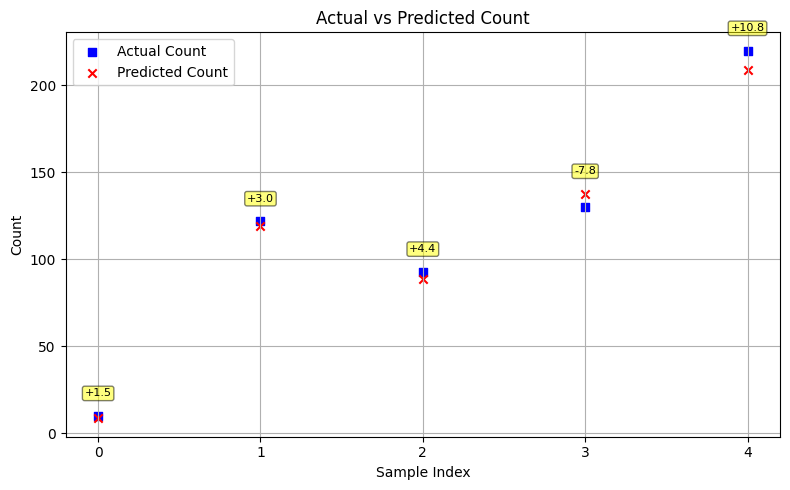

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples
x = np.arange(len(model_output))

plt.figure(figsize=(8, 5))

# Plot actual values as squares
plt.scatter(x, model_output['Actual  Count'], label='Actual Count', marker='s', color='blue')

# Plot predicted values as crosses
plt.scatter(x, model_output['Predicted Count'], label='Predicted Count', marker='x', color='red')

# Annotate with differences
for i in x:
    actual = model_output['Actual  Count'][i]
    predicted = model_output['Predicted Count'][i]
    diff = actual - predicted
    plt.text(i, max(actual, predicted) + 10, f'{diff:+.1f}', 
             ha='center', va='bottom', fontsize=8, 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))
    
plt.xlabel("Sample Index")
plt.ylabel("Count")
plt.title("Actual vs Predicted Count")
plt.xticks(x)  # Show sample indices clearly
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Congratulations! You have completed all the steps in task 6 (`Model Deploymet - Deploy on OpenShift Cluster`). 